<a href="https://colab.research.google.com/github/pravinkr/GAN-Keras/blob/master/acgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build Discriminator
Build Generator
y_train.shape: (60000,)
x_train.shape (60000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch 0: [D loss: 1.017591, acc.: 69.29%] [G loss: 1.052790, acc.: 72.86%]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch 200: [D loss: 1.088244, acc.: 78.77%] [G loss: 1.407661, acc.: 108.54%]
epoch 400: [D loss: 0.838171, acc.: 56.21%] [G loss: 1.227516, acc.: 90.74%]
epoch 600: [D loss: 0.873491, acc.: 61.35%] [G loss: 1.668293, acc.: 132.21%]
epoch 800: [D loss: 0.862231, acc.: 63.06%] [G loss: 1.267350, acc.: 93.72%]
epoch 1000: [D loss: 0.901774, acc.: 67.84%] [G loss: 1.124895, acc.: 78.33%]
epoch 1200: [D loss: 0.831545, acc.: 64.27%] [G loss: 1.041596, acc.: 78.23%]
epoch 1400: [D loss: 0.853674, acc.: 69.99%] [G loss: 1.002777, acc.: 74.47%]
epoch 1600: [D loss: 0.802505, acc.: 67.26%] [G loss: 1.018895, acc.: 83.58%]
epoch 1800: [D loss: 0.809492, acc.: 72.85%] [G loss: 1.003543, acc.: 86.82%]
epoch 2000: [D loss: 0.735529, acc.: 66.49%] [G loss: 0.820846, acc.: 76.92%]
epoch 2200: [D loss: 0.749580, acc.: 71.20%] [G loss: 0.875898, acc.: 84.24%]
epoch 2400: [D loss: 0.761203, acc.: 72.76%] [G loss: 0.696035, acc.: 68.19%]
epoch 2600: [D loss: 0.733647, acc.: 71.26%] [G loss: 0.804197, ac

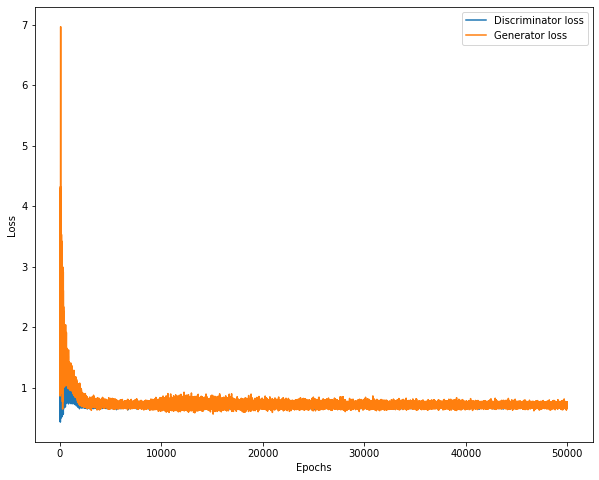

In [0]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division


import tensorflow as tf

from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D,  Dropout, Flatten, Dense, Input, Reshape
from keras.layers import Activation, Conv2DTranspose, UpSampling2D, BatchNormalization, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist, fashion_mnist
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
from PIL import Image
from tqdm import tqdm
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

class ACGAN:

	def __init__(self, rows=28, cols=28, channels=1):
		self.rows = rows
		self.cols = cols
		self.channels = channels
		self.shape = (self.rows, self.cols, self.channels)
		self.latent_size = 100
		self.sample_rows = 2
		self.sample_cols = 5
		self.sample_path = 'images'
		self.num_classes = 10

		#optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
		optimizer = Adam(0.0002, 0.5)
		
		
		image_shape = self.shape
		seed_size = self.latent_size
		
		
		#Get the discriminator and generator Models
		print("Build Discriminator")
		self.discriminator = self.build_discriminator()
		
		self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
		print("Build Generator")
		
		self.generator = self.build_generator()
		
		random_input = Input(shape=(seed_size,))
		label = Input(shape=(1,))
		
		#Pass noise/random_input and label as input to the generator
		generated_image = self.generator([random_input,label])
		
		#Put discriminator.trainable to False. We do not want to train the discriminator at this point in time
		self.discriminator.trainable = False
		
		#Pass generated image and label as input to the discriminator
		validity, label_out = self.discriminator(generated_image)
		
		#Pass radom input and label as input to the combined model
		self.combined_model = Model([random_input,label], [validity,label_out])
		self.combined_model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
		
	def build_discriminator(self):
	
		input_shape = self.shape
		model = Sequential()
		model.add(Conv2D(64, (3,3), strides=2, padding='same', input_shape=input_shape))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.4))
		
		model.add(Conv2D(128,(3,3), strides=2, padding='same'))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.4))
		
		model.add(Conv2D(256, (3,3), strides=2, padding='same'))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.4))
		
		model.add(Conv2D(512, (3,3), padding='same'))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.4))
		
		model.add(Flatten())
		
		

		#model.add(Dense(1,activation='sigmoid'))
		
		#output = model
		#inp = Input(shape=input_shape) 
		
		
		#model.summary()
		
		input_image = Input(shape=input_shape)
	
		#Extrating features from the model
		features = model(input_image)
		
		
		# AC GAN has 2 outputs, 1 for real or Fake using sigmoid activation. Another for class prediction using softmax.

		validity = Dense(1, activation='sigmoid', name='Dense_validity')(features)
		aux = Dense(self.num_classes, activation='softmax', name ='Dense_Aux')(features)

	
		return Model(input_image,[validity,aux])	

	def build_generator(self):
	
	
		seed_size = self.latent_size
		model = Sequential()
		model.add(Dense(7*7*256, input_dim=seed_size))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		
		model.add(Reshape((7,7,256)))
		model.add(Dropout(0.4))
		
		model.add(Conv2DTranspose(128,(5,5),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		model.add(UpSampling2D())
		
		model.add(Conv2DTranspose(64,(3,3),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		model.add(UpSampling2D())
		
		model.add(Conv2DTranspose(32,(3,3),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		
		model.add(Conv2DTranspose(1,(3,3),padding='same'))
		model.add(Activation('sigmoid'))
		
		noise = Input(shape=(seed_size,))
		label = Input(shape = (1,), dtype='int32')
		
		label_embeddings = Flatten()(Embedding(self.num_classes,self.latent_size)(label))
		
		
		model_input = multiply([noise,label_embeddings])
		
		generated_image = model(model_input)
		
		#model.summary()
		

		return(Model([noise,label],generated_image))


	def plot_sample_images(self, epoch, noise):
		r, c = self.sample_rows, self.sample_cols
		#noise = np.random.normal(0, 1, (r * c, self.latent_size))
		
		sampled_labels = np.arange(0, self.num_classes).reshape(-1, 1)
	
		gen_imgs = self.generator.predict([noise,sampled_labels])
		
		filename = os.path.join(self.sample_path,'%d.png'% epoch)
		fig, axs = plt.subplots(r, c)
		cnt = 0
		for i in range(r):
			for j in range(c):
				axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
				axs[i,j].axis('off')
				cnt += 1
		fig.savefig(filename)
		plt.close()


	def plot_loss(self,losses):
		"""
		@losses.keys():
			0: loss
			1: accuracy
		"""
		d_loss = [v[0] for v in losses["D"]]
		g_loss = [v[0] for v in losses["G"]]
		
		plt.figure(figsize=(10,8))
		plt.plot(d_loss, label="Discriminator loss")
		plt.plot(g_loss, label="Generator loss")
		
		plt.xlabel('Epochs')
		plt.ylabel('Loss')
		plt.legend()
		plt.show()





		
	def train(self, epochs=10000, batch_size=32, save_freq=200):
   
		seed_size = self.latent_size
		
    #Load Dataset
		(x_train,y_train),(_,_) = mnist.load_data()
		#(x_train,y_train),(_,_) = fashion_mnist.load_data()
		print("y_train.shape: {}".format(y_train.shape))
		#normalize and reset train set in range (0,1) # normalizing to (-1,1) seems to be not working.
		
		x_train = np.expand_dims(x_train, axis=-1)
		y_train = y_train.reshape(-1,1)

		#x_train = (x_train.astype('float32') / 127.5 ) - 1. # Normalizing this way doesn't work during training.
		
		x_train = x_train.astype('float32')/255.0 #Normalizing  this way does work during training.
		
  
		print("x_train.shape",x_train.shape)

		#Ground Truth. Setting real images labels to True
		y_real = np.ones((batch_size,1))

		#Setting fake images labels to False
		y_fake = np.zeros((batch_size,1))
		
    
		#fixed_seed = np.random.normal(0,1,size=[25,seed_size])
		
		cnt = 1
		
		#Generating Fixed noise to be passed for sampling with same inputs after set of epochs and seeing the results
		noise_input = np.random.normal(0,1,size=[self.sample_rows*self.sample_cols,seed_size])
		
		#Setup loss vector to store losses for Generator and Discriminator
		
		losses = {"D":[], "G":[]}

		path = self.sample_path
		if not os.path.isdir(path):
		  os.mkdir(path)

		for epoch in range(epochs):


      #Training of Discriminator. Taking random samples of batch_size #
			noise = np.random.normal(0,1,size=[batch_size,seed_size])
			
      #take random batched of indexes for x_train
			idx = np.random.randint(0,x_train.shape[0],size=batch_size)
			
			#print(idx[0:10])
			x_real, y_real_label = x_train[idx], y_train[idx]

			#Generate random labels for fake image generation
			y_fake_label = np.random.randint(0, self.num_classes, (batch_size, 1))
			
		
			#Generate some fake images
			x_fake = self.generator.predict([noise,y_fake_label])

			x = np.concatenate((x_real,x_fake))
			y_label = np.concatenate((y_real_label, y_fake_label))
			
			y_real_or_fake = np.ones([2*batch_size,1]) #putting all images as real
			y_real_or_fake[batch_size:,:] = 0 #putting 0 for fake images
			
			#Train discriminator on real and fake
			encoded_y_label = to_categorical(y_label,num_classes=self.num_classes)
			
			d_loss = self.discriminator.train_on_batch(x,[y_real_or_fake,encoded_y_label])
	 
			#Train Generator on Calculated loss
			y_real_or_fake = np.ones([batch_size, 1])

			noise = np.random.normal(0,1,size=[batch_size,seed_size])
			sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
			encoded_sampled_labels = to_categorical(sampled_labels,num_classes=self.num_classes)
			g_loss = self.combined_model.train_on_batch([noise,sampled_labels],[y_real_or_fake,encoded_sampled_labels])
			
			losses["D"].append(d_loss)
			losses["G"].append(g_loss)
			
			#Time for an update
			
			if save_freq > 0:
				if epoch % save_freq == 0:
			
					print ("epoch %d: [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], 100*g_loss[1]))
					self.plot_sample_images(epoch, noise_input)
				
					cnt+=1

		self.plot_loss(losses)

if __name__ == '__main__':
	
	gan = ACGAN()
	#gan.train(epochs=14000, batch_size=32, save_freq=200)		
	gan.train(epochs=50000)


After epoch:  0


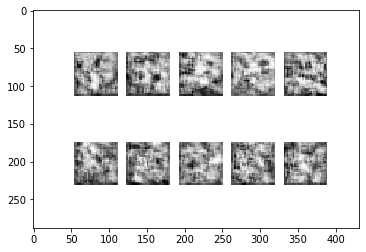

After epoch:  5000


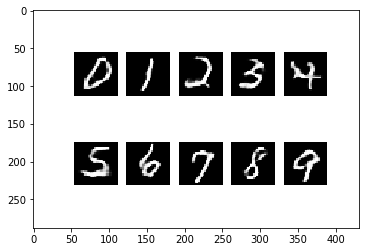

After epoch:  10000


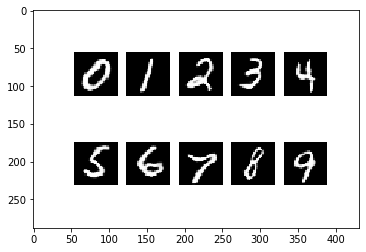

After epoch:  15000


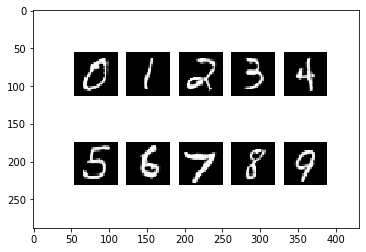

After epoch:  20000


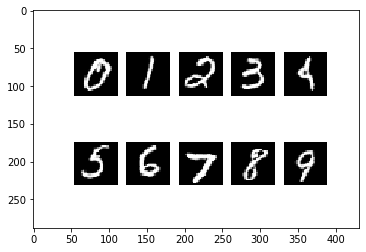

After epoch:  25000


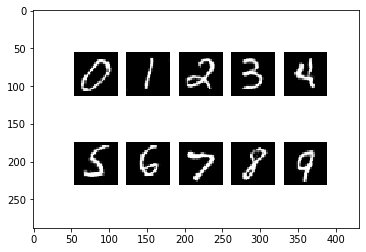

After epoch:  30000


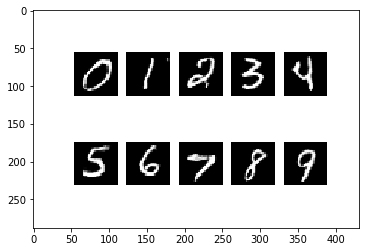

After epoch:  35000


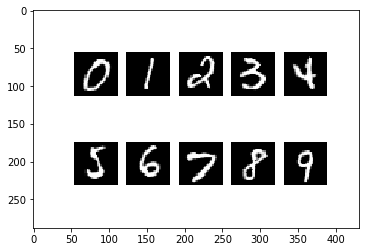

After epoch:  40000


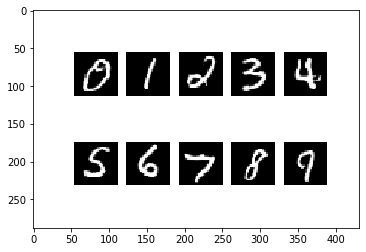

After epoch:  45000


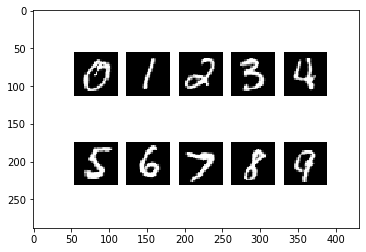

In [0]:
img_id = 0
epoch=0
for i in range(10):
  img = plt.imread("images/{}.png".format(epoch))
  print("After epoch: ",epoch)
  plt.imshow(img,label=epoch)
  #plt.figtext(img_id)
  epoch += 5000
  plt.show()